In [5]:
import pandas as pd
import random
import datetime
import numpy as np
from itertools import repeat
import pickle
import math
import time
import gurobipy as gp
from gurobipy import *

import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
%matplotlib nbagg
import random

In [6]:
def create_dataframe(excel_data_path):
    """
    Takes in order data in excel format, returns order and equipments in pandas dataframes

    """
    xls = pd.ExcelFile(excel_data_path)
    items = pd.read_excel(xls, 'items')
    bins = pd.read_excel(xls, 'bins')

    return items, bins

def sort_items(items, *columns):
    """
    :param items: items datafram
    :param columns: colums that will be sorted
    :return: sorted items dataframe
    """
    column_list = list(columns)
    bool_list = [False] * len(column_list)
    items.sort_values(by=column_list, ascending=bool_list, inplace=True)
    return items

#randomize sorting based on weight
def randomized_weight_sort(items):
    """
    :param items: dataframe
    :return: sorted dataframe based on the condition
    """
    length = len(items) if len(items) % 2 == 0 else len(items) - 1
    for i in range(0, length, 2):
        if random.random() < 0.5:
            if (0.7 < (items.iloc[i, :].weight) / (items.iloc[i + 1, :].weight) < 1.3):
                a, b = items.iloc[i, :].copy(), items.iloc[i + 1, :].copy()
                items.iloc[i, :], items.iloc[i + 1, :] = b, a
    return items


In [46]:
filepath="C:/Users/Ashrafur.Rahman/OneDrive - Blume Global/Data and Codes/Container Loading/data/3d-bin-packing/3d-bin-packing-toy-large-70-orders.xlsx"


items_data, bins_data=create_dataframe(filepath)
items_data=sort_items(items_data,'volume','weight')
items_data=randomized_weight_sort(items_data)

In [47]:
bins_data

,bin,type,length,height,width,volume,weight
0,1,53-ft,53,9,8.5,4054.5,57000
1,2,53-ft,53,9,8.5,4054.5,57000
2,3,40-ft,40,8,8.5,2720.0,48200
3,4,40-ft,40,8,8.5,2720.0,48200
4,5,20-ft,20,8,8.5,1360.0,42000
5,6,20-ft,20,8,8.5,1360.0,42000
6,7,20-ft,20,8,8.5,1360.0,42000


In [48]:
items_data

,item,length,height,width,volume,weight,p_class,stackability,customer,priority
3,4,6,5,6,180,859,D,0,1,1
46,47,6,5,5,150,305,B,1,2,2
58,59,6,4,6,144,799,A,1,2,2
44,45,6,4,6,144,626,D,1,1,2
36,37,6,4,5,120,535,D,1,2,3
...,...,...,...,...,...,...,...,...,...,...
25,19,4,2,3,24,910,C,1,2,1
68,15,4,2,3,24,725,C,1,3,3
14,69,3,2,4,24,781,C,0,1,3
56,57,3,2,4,24,594,D,1,1,3


In [49]:
length=len(items_data) if len(items_data)%2==0 else len(items_data)-1
for i in range(0,length,2):
    if random.random()<0.5:
        if (0.7< items_data.iloc[i].weight/items_data.iloc[i+1].weight< 1.3):
            a, b = items_data.iloc[i, :].copy(), items_data.iloc[i+1, :].copy()
            items_data.iloc[i, :], items_data.iloc[i+1, :] = b, a


In [50]:
ww=dict(zip(items_data.item,items_data.width))
ll=dict(zip(items_data.item,items_data.length))
hh=dict(zip(items_data.item,items_data.height))
weight=dict(zip(items_data.item,items_data.weight))
volume=dict(zip(items_data.item,items_data.volume))
p_class=dict(zip(items_data.item,items_data.p_class))
stack_item=dict(zip(items_data.item,items_data.stackability))
customer=dict(zip(items_data.item,items_data.customer))
priority=dict(zip(items_data.item,items_data.priority))
#W=dict(zip(bins.bin,bins.width))
#H=dict(zip(bins.bin,bins.height))
#L=dict(zip(bins.bin,bins.length))

In [51]:
stack_item

{4: 0,
 47: 1,
 45: 1,
 59: 1,
 37: 1,
 1: 1,
 7: 1,
 29: 1,
 70: 0,
 18: 1,
 9: 1,
 62: 1,
 39: 1,
 40: 1,
 14: 1,
 32: 1,
 36: 1,
 17: 1,
 2: 1,
 38: 1,
 35: 1,
 42: 1,
 54: 1,
 33: 1,
 46: 1,
 55: 1,
 22: 1,
 64: 1,
 10: 1,
 23: 1,
 31: 1,
 63: 1,
 16: 1,
 66: 1,
 8: 1,
 5: 1,
 24: 1,
 67: 1,
 13: 1,
 11: 1,
 43: 1,
 44: 1,
 50: 1,
 51: 1,
 20: 1,
 61: 1,
 28: 1,
 56: 1,
 49: 1,
 30: 1,
 68: 0,
 60: 1,
 53: 1,
 21: 1,
 34: 1,
 27: 1,
 48: 1,
 52: 1,
 3: 1,
 25: 0,
 58: 1,
 65: 1,
 41: 1,
 6: 1,
 26: 1,
 19: 1,
 15: 1,
 69: 0,
 57: 1,
 12: 0}

In [52]:
bins_dim=dict(zip(bins_data.bin,zip(bins_data.type,bins_data.length,bins_data.height,bins_data.width,bins_data.volume,bins_data.weight)))


#bin characteristics
L={}
W={}
H={}
volume_capacity={}
weight_capacity={}
volume_utilization={}
weight_utilization={}
#bins=[1,2,3]
bins=bins_data.bin.tolist()
zones=4

orientations=['o1','o2','o3','o4','o5','o6']

weight_capacity_zone={}
for e in bins:
    L[e]=bins_dim[e][1]
    W[e]=bins_dim[e][2]
    H[e]=bins_dim[e][3]

    volume_capacity[e]=bins_dim[e][4]
    weight_capacity[e]=bins_dim[e][5]

In [53]:
L

{1: 53, 2: 53, 3: 40, 4: 40, 5: 20, 6: 20, 7: 20}

In [54]:
volume_capacity

{1: 4054.5, 2: 4054.5, 3: 2720.0, 4: 2720.0, 5: 1360.0, 6: 1360.0, 7: 1360.0}

In [55]:
#iteration results
IP_iter={}
volume_utilization_iter={}
weight_utilization_iter={}
c_gravity_y_iter={}
dev_gravity_center_iter={}

unused_bins_iter={}
used_bins_iter={}

x_iter={}
y_iter={}
z_iter={}

l_iter={}
w_iter={}
h_iter={}

iterations=100

In [56]:
%%capture output --no-stderr

for it in range(1,iterations+1):
    print("======================================")
    print("^^^ For iteration ",it, ' in ', iterations)
    print("======================================")

    I=items_data.item.tolist() #list of items need to be packed
    IU=[x for x in I]
    print("I: ",I)
    print("IU: ",IU)

    #vehicle level properties
    IP_e={} #item packed in bins e

    x_e={} #x coordinate of insertion point (FBL) of items in bins e
    y_e={} #y coordinate of insertion point (FBL) of items in bins
    z_e={} #z coordinate of insertion point (FBL) of items in bins

    l_e={} #length of items in bins
    w_e={} #width of items in bins
    h_e={} #height of items in bins

    stack_e={}

    volume_utilization_e={} #volume utilized in bins
    weight_utilization_e={} #weight utilized in bins

    volume_e= {e:0 for e in bins} #volume loaded in bin
    weight_e= {e:0 for e in bins} #weight loaded in bin

    c_gravity_y_e={} #center of gravity along width of bins
    dev_gravity_center_e={}  #deviation of center of gravity along width of bins

    volume_loaded_e={}#volume loaded in bins
    weight_loaded_e={}#volume loaded in bins

    c_gravity_item_x={} #center of gravity of items along length of bins
    c_gravity_item_y={} #center of gravity of items along width of bins
    c_gravity_item_z={} #center of gravity of items along height of bins

    used_bins=[]

    unused_bins=[b for b in bins]

    for e in bins:

        p_item_z={} #stac
        #if IU==[]:
            #unused_bins.remove(e)
            #continue
        l={} #length of items
        w={} #width  of items
        h={} #height  of items
        o={} #orientation of items
        sa={} #surface area of items
        sa_p={} #surface area available at potential point p

        x={} #x coordinate of insertion point (RBL) of items
        y={} #y coordinate of insertion point (RBL) of items
        z={} #z coordinate of insertion point (RBL) of items

        stack_p={} #stackability at potential point p

        #if total_volume_e[e]<volume_capacity[e]:
        print("____packing starts______")
        print(e, " in ", bins)
        print('IU: ', IU)

       #start with (0,0,0) in the bin
        P=[(0,0,0)] #starting potential point in
        print("  **** potential points ", P)
        under_p={} # item under potential point p

        l_available_p={} #lenght available at potential point p
        w_available_p={} #width available at potential point p
        l_available_p[(0,0,0)]=L[e] #initial available length
        w_available_p[(0,0,0)]=W[e] #initial available wdidth

        sa_p[(0,0,0)]=L[e]*W[e] #initial suface area for potential point (0,0,0)
        under_p[(0,0,0)]=0 #item under p
        stack_p[(0,0,0)]=1
        p_item_z[(0,0,0)]=(0,0)

        #length, width, height of initial p
        l[0]=L[e] #lenght of item 0
        w[0]=W[e]
        h[0]=H[e]

        #items packed list, initial list is empty
        IP=[]
        IUU=[] #items unpakced on volume criterion

        #each bin is divided in four zones. Create a list of size 4 to compute weight in
        #each zone
        weights_in_zones=[0]*zones #weight loaded in each zone =0
        weight_by_item_in_zones={} #weight added by items in each zone
        weight_capacity_zone=[weight_capacity[e]/zones]*zones #zone capacity list

        print("######################################################")
        while IU!=[] :
            print("===while IU!= 0" ,IU)
            print("===IU:" ,IU)
            print('===available potential points: ',P)
            I_retry=[] #items that needs to be retried packing

            loaded_weight_p={} #weight loaded at potential point p

            #IU=IU+IUU


            for i in IU:
                if volume_e[e]+volume[i]>volume_capacity[e]:
                    IUU.append(i)


                else:
                    print("### Evaluation box ", i, "in IU ",IU)
                    o[i]=random.choice(orientations)

                    if o[i]=='o1' :
                        l[i]=ll[i]
                        w[i]=ww[i]
                        h[i]=hh[i]
                    if o[i]=='o2' :
                        l[i]=ww[i]
                        w[i]=ll[i]
                        h[i]=hh[i]
                    if o[i]=='o3' :
                        l[i]=ww[i]
                        w[i]=hh[i]
                        h[i]=ll[i]
                    if o[i]=='o4' :
                        l[i]=hh[i]
                        w[i]=ww[i]
                        h[i]=ll[i]
                    if o[i]=='o5' :
                        l[i]=hh[i]
                        w[i]=ll[i]
                        h[i]=ww[i]
                    if o[i]=='o6' :
                        l[i]=ll[i]
                        w[i]=hh[i]
                        h[i]=ww[i]

                    sa[i]=l[i]*w[i]

                    print(" length, width, and height " , l,w,h)

                    p_feasible=[]

                    print(" ====start Loading ")
                    print('for ', i, ' in ', IU)
                    #print('i : : ',i)
                    #MPL_x= max([x[k]+l[k] for k in IP])
                   #MPL_y= max([y[k]+w[k] for k in IP])
                    #MPL_y= max([h[k]+h[k] for k in IP])

                        #weights_in_zones[i]=loaded_weight_zone[i]+weights_in_zones[i]

                    sa_ratio=0
                    for p in P:
                        print('----start evaluating P')
                        print('for ',p,' in ', P)

                       # zone_ratio=[]
                        loaded_weight=[]

                        #print('Available Potentail points', P)
                        #print('test Potential point: ',p)

                        if p[0]+l[i] <=L[e]/4:
                            print('first weight condition')
                            zone_ratio=[1,0,0,0]
                        if p[0]<(L[e]/4) and p[0]+l[i]>(L[e]/4) and p[0]+l[i]<=(L[e]/2):
                            print('2 nd weight condition')
                            zone_ratio= [(L[e]/4-p[0])/l[i] ,(p[0]+l[i]-L[e]/4)/l[i],0,0]
                        if  p[0]<L[e]/4 and p[0]+l[i]> L[e]/2 and  p[0]+l[i]<=3*L[e]/4:
                            print('3 rd weight condition')
                            zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                        if  p[0]<L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                            print('4th weight condition')
                            zone_ratio=[(L[e]/4-p[0])/l[i],(L[e]/4)/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if  p[0]>= (L[e]/4) and p[0]+l[i]<=(L[e]/2) :
                            print('5th weight condition')
                            zone_ratio=[0,1,0,0]
                        if  p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]> L[e]/2  and p[0]+l[i]<=3*L[e]/4:
                            print('6th weight condition')
                            zone_ratio=[0,(L[e]/2-p[0])/l[i],(p[0]+l[i]-L[e]/2)/l[i],0]
                        if p[0]>=L[e]/4 and p[0]<L[e]/2  and p[0]+l[i]>3*L[e]/4 :
                            print('7th weight condition')
                            zone_ratio=[0,(L[e]/2-p[0])/l[i],(L[e]/4)/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if p[0]>=L[e]/2 and p[0]+l[i]<=3*L[e]/4:
                            print('8th weight condition')
                            zone_ratio=[0,0,1,0]
                        if  p[0]>=L[e]/2 and p[0]<3*L[e]/4 and p[0]+l[i]>3*L[e]/4 :
                            print('9th weight condition')
                            zone_ratio=[0,0,(3*L[e]/4-p[0])/l[i],(p[0]+l[i]-3*L[e]/4)/l[i]]
                        if p[0]>=3*L[e]/4 and p[0]+l[i]<=L[e]:
                            print('10th weight condition')
                            zone_ratio=[0,0,0,1]
                        loaded_weight=[x*weight[i] for x in zone_ratio]
                            #weights_in_zones[pp]=weights_in_zones[pp]+loaded_weight[pp]
                            #print('weight in zone ',pp,weights_in_zones[pp]
                        loaded_weight_p[p]=loaded_weight
                        print("loaded weight for", p, ":",loaded_weight_p )



                        print('------evaluating loaded weight.... ')
                        if loaded_weight[0] <=(weight_capacity_zone[0]-weights_in_zones[0]) and loaded_weight[1] <=(weight_capacity_zone[1]-weights_in_zones[0]) and loaded_weight[2] <=(weight_capacity_zone[2]-loaded_weight[2]) and loaded_weight[3] <=(weight_capacity_zone[3]-weights_in_zones[3]):
                            print('....loaded weight criterion worked')
                            print('evluating length and width of bin....  ')
                            #print('for, p[0]: ',p[0])

                            if p[0]+l[i] <=L[e] and p[1]+w[i]<=W[e] and p[2]+h[i]<=H[e]:
                                print("...bin length and bin width criteria worked")
                                #if sa_p[p]>sa[i]:
                                print('evluating availale_lenght and availabl_width....  ')
                                if l[i]<=l_available_p[p] and w[i]<=w_available_p[p]:
                                    print("...availale_length and availabl_width criteria worked")
                                    print("Evaluating surface area....")
                                    if sa[i]/sa_p[p]>=sa_ratio:
                                        print("...surface criterion worked")
                                        sa_ratio=sa[i]/sa_p[p]
                                        p_feasible.append(p)
                                        print('----sa ratio:', sa_ratio)


                    #z_for_stackability={}

                    print('-----feaible p:', p_feasible)
                    if p_feasible==[]:
                        I_retry.append(i)
                        print("no feasible potential points for: ", i)
                        print('I_retry: ',I_retry)
                        continue

                    elif len(p_feasible)>1:
                            x_p= min([point[0] for point in p_feasible])
                            x_y=min([point[1] for point in p_feasible])
                            x_z=min([point[2] for point in p_feasible])
                            #p_best=[ x for x in p_feasible if x[0]==x_p and x[1]==x_y and x[2]==x_z][0]
                            p_best=[ x for x in p_feasible if x[0]==x_p ][0]

                    elif len(p_feasible)==1:
                            p_best=p_feasible[0]

                    if p_best:
                        print('b===est potential point p_best: ',p_best )

                        weights_in_zones=[sum(i) for i in zip(weights_in_zones, [weight for weight in loaded_weight_p[p_best]])]
                        weight_by_item_in_zones[i]= weights_in_zones


                        print('best potential point: ',p_best )
                        #item to be placed at x[i],y[i],z[i]
                        x[i]=p_best[0]
                        y[i]=p_best[1]
                        z[i]=p_best[2]

                        l[i]=l[i]
                        w[i]=w[i]
                        h[i]=h[i]


                        #z_for_stackabiliyt[p_best]=z[i]+h[i]

                        #create new potential points
                        P.append((x[i]+l[i],y[i],z[i]))
                        P.append((x[i],y[i]+w[i],z[i]))
                        P.append((x[i],y[i],z[i]+h[i]))

                        print ("*** P after adding new  potential points :", P)


                        sa_p[(x[i]+l[i],y[i],z[i])]=sa_p[p_best]-sa[i]
                        sa_p[(x[i],y[i]+w[i],z[i])]=sa_p[p_best]-sa[i]
                        sa_p[(x[i],y[i],z[i]+h[i])]=sa[i]

                        under_p[(x[i]+l[i],y[i],z[i])]=under_p[p_best]
                        under_p[(x[i],y[i]+w[i],z[i])]=under_p[p_best]
                        under_p[(x[i],y[i],z[i]+h[i])]=i


                        stack_p[(x[i]+l[i],y[i],z[i])]=stack_p[p_best]
                        stack_p[(x[i],y[i]+w[i],z[i])]=stack_p[p_best]
                        stack_p[(x[i],y[i],z[i]+h[i])]=stack_item[i]


                        l_available_p[(x[i]+l[i],y[i],z[i])]=l_available_p[p_best]-l[i]
                        l_available_p[(x[i],y[i]+w[i],z[i])]=l_available_p[p_best]
                        l_available_p[(x[i],y[i],z[i]+h[i])]=l[i]

                        w_available_p[(x[i]+l[i],y[i],z[i])]=w_available_p[p_best]
                        w_available_p[(x[i],y[i]+w[i],z[i])]=w_available_p[p_best]-w[i]
                        w_available_p[(x[i],y[i],z[i]+h[i])]=w[i]


                        P.remove(p_best)
                        print("+++++ removed potential points: ", p_best)
                        print ("**** P after removing p_best  potential points :", P)

                        if stack_p[(x[i],y[i],z[i]+h[i])]==0:
                            P.remove((x[i],y[i],z[i]+h[i]))

                        if l_available_p[(x[i]+l[i],y[i],z[i])]==0:
                            P.remove((x[i]+l[i],y[i],z[i]))
                        if w_available_p[(x[i],y[i]+w[i],z[i])]==0:
                            P.remove((x[i],y[i]+w[i],z[i]))

                        for pp, t1 in enumerate(P):
                            for t2 in P[pp+1:]:
                                if t1[1:]==t2[1:]:
                                    if t1[0]<t2[0]:
                                        P.remove(t2)
                                    else:
                                        P.remove(t1)
                        for ppp, tt1 in enumerate(P):
                            for tt2 in P[ppp+1:]:
                                if tt1[0::2]==tt2[0::2]:
                                    if tt1[1]<tt2[1]:
                                        P.remove(tt2)
                                    else:
                                        P.remove(tt1)

                        IP.append(i)

                        updated_volume=volume_e[e]+volume[i]
                        updated_weight=weight_e[e]+weight[i]
                        volume_e.update({e:updated_volume})
                        weight_e.update({e:updated_weight})

                        print("@@@@ IP : ",IP)
                        #volume_loaded.append(volume[i])
                        #weight_loaded.append(weight[i])
                        c_gravity_item_x[i]=x[i]+l[i]/2
                        c_gravity_item_y[i]=y[i]+w[i]/2
                        c_gravity_item_z[i]=z[i]+h[i]/2
                        print("@@@@ c_gravity_item_y: ", c_gravity_item_y)

            print('Before going to new bin or retrying:')
            print('I_retry: ',I_retry)
            print('IU: ',IU)
            print('IP: ',IP)
            print('IUU: ',IUU)
            print("=============IU,IP,I_retry")
            if  I_retry==[] or  set(I_retry)==set(IU):
                IU=[x for x in IU if x not in IP]
                #sorted(IU, key={e:i for i,e in enumerate(I)}.get)
                print("break")

                print(IU,IP,I_retry)

                break

            if I_retry!=[] and set(I_retry)!=set(IU):
                #if I_retry!=IU:
                IU=[x for x in I_retry]
                print('going to retry')

                print(IU,IP,I_retry)

                continue

        IP_e[e]=IP
        print("&&&&& IP_e[e] for ", e, ": ",IP_e[e])
        print("&&&& c_gravity_item_y: ",c_gravity_item_y )

        x_e[e]=x
        y_e[e]=y
        z_e[e]=z

        stack_e[e]=stack_p
        l_e[e]=l
        w_e[e]=w
        h_e[e]=h

        if IP_e[e]!=[]:
            c_gravity_y_e[e]=sum(c_gravity_item_y[i]*weight[i] for i in IP_e[e])/sum(weight[i] for i in IP_e[e])
            #dev_gravity_center[e]=(W[e]/2)-c_gravity_y[e]
            print("===================================== c_gravity_y_e :",c_gravity_y_e)
        else:
            c_gravity_y_e[e]=0
            #dev_gravity_center[e]=INF
        #print(c_gravity_y[e])
        #if W[e]*(1/3) <c_gravity_y[it]<W[e]*(2/3):
        #dev_gravity_center[e]=(W[e]/2)-c_gravity_y[e]
        #else:
        #    dev_gravity_center[e]="too far"

        volume_loaded_e[e]=sum(volume[ip] for ip in IP_e[e])
        volume_utilization_e[e]=(volume_loaded_e[e])/volume_capacity[e]

        weight_loaded_e[e]=sum(weight[ip] for ip in IP_e[e])
        weight_utilization_e[e]=(weight_loaded_e[e])/weight_capacity[e]
        used_bins.append(e)

    print('after each iteration:')
    print('IP_e: ',IP_e)
    IP_iter[it]=IP_e

    used_bins_iter[it]=used_bins
    #unused_bins_iter[it]=unused_bins

    volume_utilization_iter[it]=volume_utilization_e
    weight_utilization_iter[it]=weight_utilization_e
    c_gravity_y_iter[it]=c_gravity_y_e
    #dev_gravity_center_iter=dev_gravity_center

    x_iter[it]=x_e
    y_iter[it]=y_e
    z_iter[it]=z_e

    l_iter[it]=l_e
    w_iter[it]=w_e
    h_iter[it]=h_e

print("a")
with open('output.txt', 'w') as f:
    f.write(str(output))


In [29]:
stack_p

{(0, 0, 0): 1}

In [30]:
used_bins_iter

{1: [1, 2, 3, 4, 5, 6, 7],
 2: [1, 2, 3, 4, 5, 6, 7],
 3: [1, 2, 3, 4, 5, 6, 7],
 4: [1, 2, 3, 4, 5, 6, 7],
 5: [1, 2, 3, 4, 5, 6, 7],
 6: [1, 2, 3, 4, 5, 6, 7],
 7: [1, 2, 3, 4, 5, 6, 7],
 8: [1, 2, 3, 4, 5, 6, 7],
 9: [1, 2, 3, 4, 5, 6, 7],
 10: [1, 2, 3, 4, 5, 6, 7],
 11: [1, 2, 3, 4, 5, 6, 7],
 12: [1, 2, 3, 4, 5, 6, 7],
 13: [1, 2, 3, 4, 5, 6, 7],
 14: [1, 2, 3, 4, 5, 6, 7],
 15: [1, 2, 3, 4, 5, 6, 7],
 16: [1, 2, 3, 4, 5, 6, 7],
 17: [1, 2, 3, 4, 5, 6, 7],
 18: [1, 2, 3, 4, 5, 6, 7],
 19: [1, 2, 3, 4, 5, 6, 7],
 20: [1, 2, 3, 4, 5, 6, 7],
 21: [1, 2, 3, 4, 5, 6, 7],
 22: [1, 2, 3, 4, 5, 6, 7],
 23: [1, 2, 3, 4, 5, 6, 7],
 24: [1, 2, 3, 4, 5, 6, 7],
 25: [1, 2, 3, 4, 5, 6, 7],
 26: [1, 2, 3, 4, 5, 6, 7],
 27: [1, 2, 3, 4, 5, 6, 7],
 28: [1, 2, 3, 4, 5, 6, 7],
 29: [1, 2, 3, 4, 5, 6, 7],
 30: [1, 2, 3, 4, 5, 6, 7],
 31: [1, 2, 3, 4, 5, 6, 7],
 32: [1, 2, 3, 4, 5, 6, 7],
 33: [1, 2, 3, 4, 5, 6, 7],
 34: [1, 2, 3, 4, 5, 6, 7],
 35: [1, 2, 3, 4, 5, 6, 7],
 36: [1, 2, 3, 4, 5, 6, 7],
 

In [31]:
volume_utilization_iter

{1: {1: 0.9949438895054877,
  2: 0.1107411518066346,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0},
 2: {1: 0.9199654704649155,
  2: 0.22123566407695153,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0},
 3: {1: 0.8277222838821063,
  2: 0.3134788506597608,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0},
 4: {1: 0.9988901220865705,
  2: 0.028116907140214576,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0},
 5: {1: 0.9589345172031076,
  2: 0.1822666173387594,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0},
 6: {1: 0.9791589591811567,
  2: 0.16204217536071033,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0},
 7: {1: 0.9986434825502528,
  2: 0.12627944259464793,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0},
 8: {1: 0.9387100752250586,
  2: 0.2024910593168085,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0},
 9: {1: 0.9981502034776175,
  2: 0.05771365149833518,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0},
 10: {1: 0.9964237267233937,
  2: 0.09816253545443335,
  3

In [32]:
max_volume_utilization_iter={}
for it,bins in volume_utilization_iter.items():
    maximum=max(v for v in bins.values())
    max_volume_utilization_iter[it]=maximum

In [33]:
max_weight_utilization_iter={}
for it,bins in weight_utilization_iter.items():
    max_w=max(v for v in bins.values())
    max_weight_utilization_iter[it]=max_w

In [34]:
modified_weight_utilization={}
for it,bins in weight_utilization_iter.items():
    used_bins=list((bins.values()))
    x=[i for i in used_bins if i!=0][:-1]
    avg=sum(v for v in x )/len(x)
    modified_weight_utilization[it]=avg
modified_volume_utilization={}
for it,bins in volume_utilization_iter.items():
    used_bins=list((bins.values()))
    x=[i for i in used_bins if i!=0][:-1]
    avg=sum(v for v in x )/len(x)
    modified_volume_utilization[it]=avg
Avg_c_gravity_y_iter={}
for it,bins in c_gravity_y_iter.items():
    avg=sum(v for v in bins.values() if v>0)/2
    Avg_c_gravity_y_iter[it]=avg
dev_Avg_c_gravity_y_iter={a:abs(b-5) for a,b in Avg_c_gravity_y_iter.items() }

max_iter_volume = max(modified_volume_utilization, key=modified_volume_utilization.get)
max_iter_weight = max(modified_weight_utilization, key=modified_weight_utilization.get)
min_iter_gravity=min(dev_Avg_c_gravity_y_iter, key=dev_Avg_c_gravity_y_iter.get)

(max_iter_volume,max_iter_weight,min_iter_gravity)

(19, 23, 28)

In [35]:
modified_volume_utilization

{1: 0.9949438895054877,
 2: 0.9199654704649155,
 3: 0.8277222838821063,
 4: 0.9988901220865705,
 5: 0.9589345172031076,
 6: 0.9791589591811567,
 7: 0.9986434825502528,
 8: 0.9387100752250586,
 9: 0.9981502034776175,
 10: 0.9964237267233937,
 11: 0.9946972499691701,
 12: 0.8181033419657171,
 13: 0.8669379701566161,
 14: 0.9944506104328524,
 15: 0.9993834011592059,
 16: 0.928597854236034,
 17: 0.9981502034776175,
 18: 0.9993834011592059,
 19: 0.9996300406955235,
 20: 0.9749660870637563,
 21: 0.9525218892588482,
 22: 0.8928351214699717,
 23: 0.977432482426933,
 24: 0.9991367616228881,
 25: 0.9468491799235418,
 26: 0.9976569244049821,
 27: 0.9927241336786287,
 28: 0.9974102848686645,
 29: 0.9461092613145887,
 30: 0.9986434825502528,
 31: 0.8706375632013812,
 32: 0.9638673079294611,
 33: 0.9956838081144408,
 34: 0.8198298187199408,
 35: 0.9996300406955235,
 36: 0.9988901220865705,
 37: 0.7695153533111357,
 38: 0.9988901220865705,
 39: 0.8185966210383524,
 40: 0.9996300406955235,
 41: 0.5646

<IPython.core.display.Javascript object>


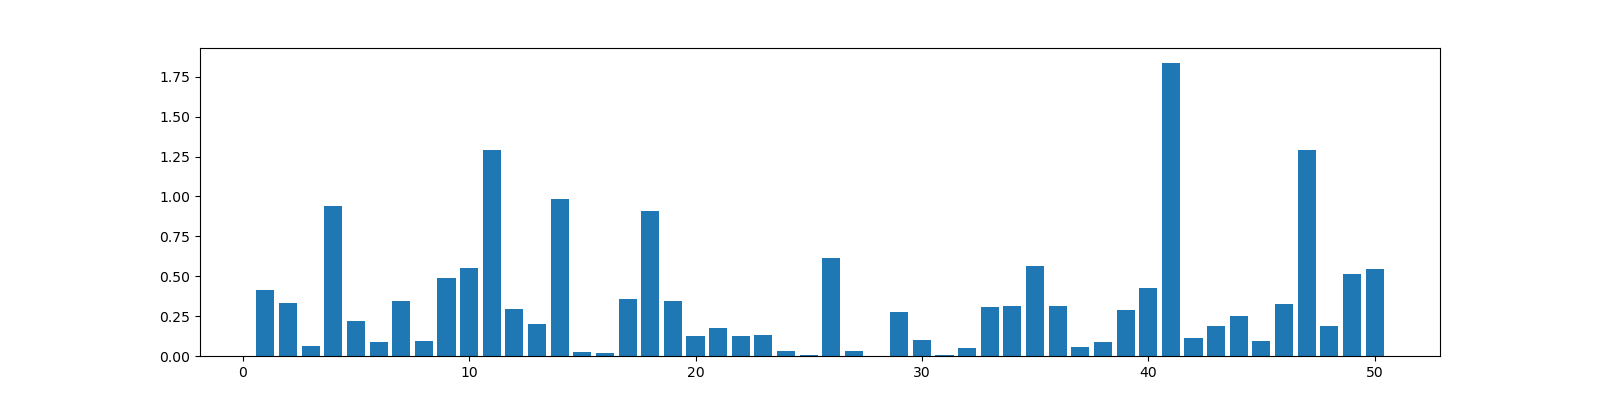

<BarContainer object of 50 artists>

In [36]:
iterations,deviations=zip(*dev_Avg_c_gravity_y_iter.items())
fig = plt.figure(figsize=(16 ,4))
plt.bar(iterations,deviations)

<IPython.core.display.Javascript object>


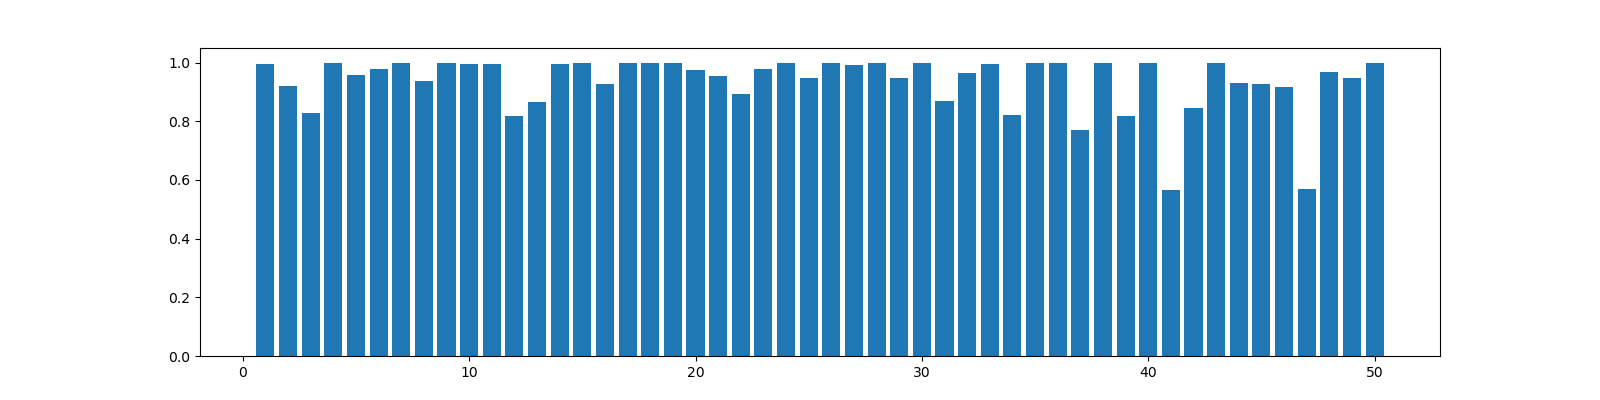

<BarContainer object of 50 artists>

In [37]:
iterations,vol_util=zip(*modified_volume_utilization.items())
fig = plt.figure(figsize=(16 ,4))
plt.bar(iterations,vol_util)

<IPython.core.display.Javascript object>


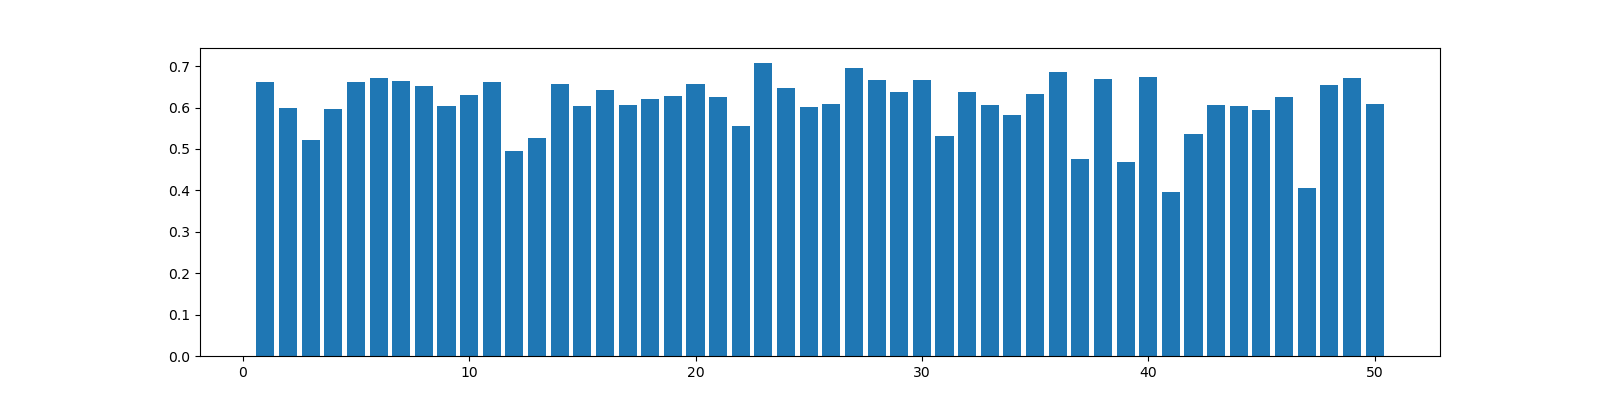

<BarContainer object of 50 artists>

In [38]:
iterations,weight_util=zip(*modified_weight_utilization.items())
fig = plt.figure(figsize=(16 ,4))
plt.bar(iterations,weight_util)

In [39]:
max(Avg_c_gravity_y_iter.values())

6.838944952054831

In [40]:
Avg_weight_utilization_iter={}
for it,bins in weight_utilization_iter.items():
    avg=sum(v for v in bins.values() if v>0)/2
    Avg_weight_utilization_iter[it]=avg


In [41]:
Avg_volume_utilization_iter={}
for it,bins in volume_utilization_iter.items():
    avg=sum(v for v in bins.values() if v>0)/2
    Avg_volume_utilization_iter[it]=avg

In [42]:
Avg_weight_utilization_iter

{1: 0.38081578947368416,
 2: 0.4104210526315789,
 3: 0.41042105263157896,
 4: 0.3152719298245614,
 5: 0.41042105263157896,
 6: 0.41042105263157896,
 7: 0.39062280701754387,
 8: 0.4104210526315789,
 9: 0.3329298245614035,
 10: 0.356719298245614,
 11: 0.33917543859649124,
 12: 0.4104210526315789,
 13: 0.4104210526315789,
 14: 0.35393859649122805,
 15: 0.31437719298245614,
 16: 0.41042105263157896,
 17: 0.3272280701754386,
 18: 0.3503157894736842,
 19: 0.3354561403508772,
 20: 0.4104210526315789,
 21: 0.41042105263157896,
 22: 0.4104210526315789,
 23: 0.41042105263157896,
 24: 0.3762017543859649,
 25: 0.4104210526315789,
 26: 0.3362631578947368,
 27: 0.41042105263157896,
 28: 0.4021929824561403,
 29: 0.4104210526315789,
 30: 0.4104210526315789,
 31: 0.4104210526315789,
 32: 0.41042105263157896,
 33: 0.31895614035087716,
 34: 0.41042105263157896,
 35: 0.3499824561403509,
 36: 0.39885087719298246,
 37: 0.41042105263157896,
 38: 0.40521052631578947,
 39: 0.41042105263157896,
 40: 0.390622807

In [43]:
list(max_weight_utilization_iter.values())

[0.6612807017543859,
 0.5984736842105263,
 0.5214912280701754,
 0.5971578947368421,
 0.6626140350877193,
 0.6715087719298246,
 0.6642280701754386,
 0.6527017543859649,
 0.6048245614035088,
 0.6309473684210526,
 0.6618947368421053,
 0.49394736842105263,
 0.5275438596491228,
 0.6557017543859649,
 0.603280701754386,
 0.6426666666666667,
 0.6065964912280701,
 0.619859649122807,
 0.6283684210526316,
 0.6571929824561403,
 0.6257543859649123,
 0.5565438596491228,
 0.7083157894736842,
 0.6472456140350877,
 0.6011052631578947,
 0.609280701754386,
 0.6963333333333334,
 0.6654736842105263,
 0.6363333333333333,
 0.6665614035087719,
 0.5308245614035088,
 0.638421052631579,
 0.6049824561403508,
 0.5819122807017544,
 0.6336315789473684,
 0.6861929824561404,
 0.4745964912280702,
 0.6677894736842105,
 0.46856140350877196,
 0.6732982456140351,
 0.4896140350877193,
 0.5370526315789473,
 0.6053157894736843,
 0.604,
 0.5942105263157895,
 0.6243157894736842,
 0.5563157894736842,
 0.6551754385964912,
 0.6721

In [44]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


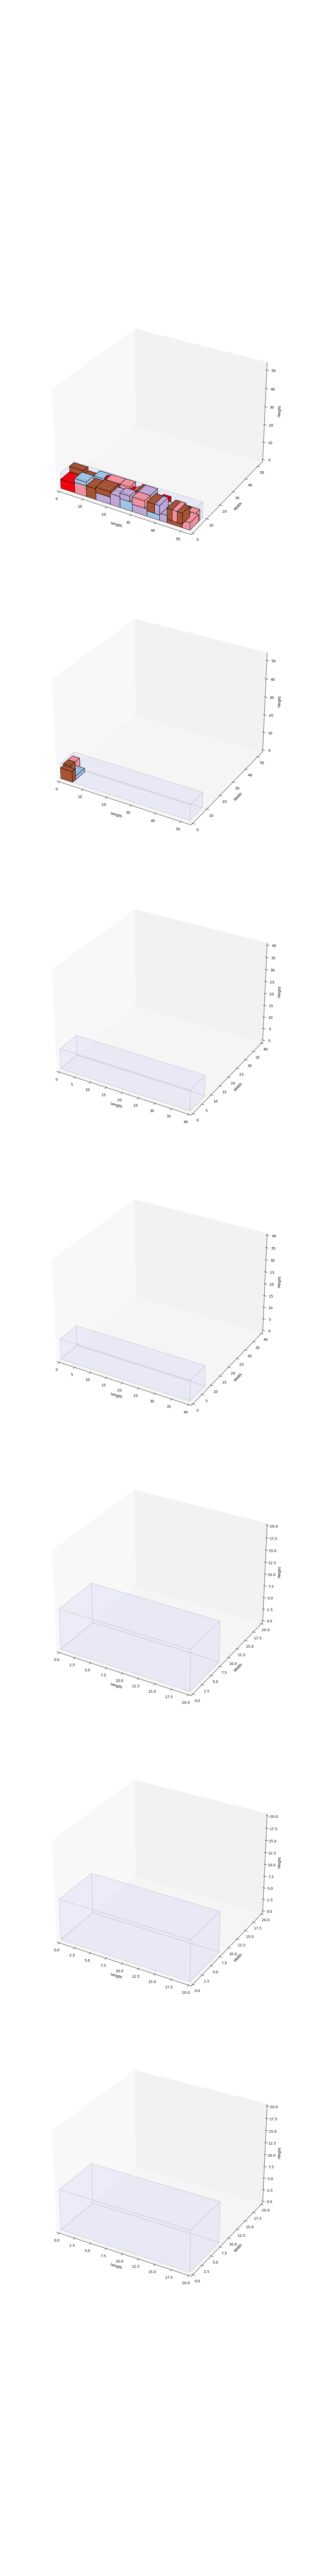

In [45]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mycolorpy import colorlist as mcp

from itertools import product
%matplotlib inline
%matplotlib nbagg
from matplotlib import cm

used_iter=max_iter_volume
flb={}
flt={}
frt={}
frb={}

rlb={}
rlt={}
rrt={}
rrb={}


nrows=len(bins)
fig = plt.figure(figsize=(12 ,100))


colors={}
classes=list(set(p_class.values()))
#size=len(set(p_class.values()))
c=mcp.gen_color(cmap="Paired",n=len(classes))
for i in range(len(classes)):
    colors[classes[i]]=c[i]
color={}
for  i,value in p_class.items():
    if stack_item[i]!=0:
        color[i]=colors[value]
    else:
        color[i]='red'

# create list of corners
#z = list(product([-1,1], repeat=3))
for e in bins:

    x={}
    y={}
    z={}

    l={}
    w={}
    h={}


    ax = fig.add_subplot(nrows,1,e, projection='3d')
    FLB=(0,0,0)
    FLT=(0,0,H[e])
    FRT=(0,W[e],H[e])
    FRB=(0,W[e],0)

    RLB=(L[e],0,0)
    RLT=(L[e],0,H[e])
    RRT=(L[e],W[e],H[e])
    RRB=(L[e],W[e],0)

    bin_verts=[  [FLB,FLT,FRT,FRB],
             [FLB,FLT,RLT,RLB],
             [FLT,FRT,RRT,RLT],
             [RRT,FRT,FRB,RRB],
             [RLB,FLB,FRB,RRB],
             [RLB,RLT,RRT,RRB ]
             ]
    ax.set_xlim3d(0,L[e])
    ax.set_ylim3d(0,L[e])
    ax.set_zlim3d(0,L[e])
    ax.set_xlabel('Length')
    ax.set_ylabel('Width')
    ax.set_zlabel('Height')
    ax.grid(False)
# plot sides
    ax.add_collection3d(Poly3DCollection(bin_verts,facecolors='blue', linewidths=0.25, edgecolors='grey', alpha=.025))

    for c in p_class:
        c=mcp.gen_color(cmap="seismic",n=5)
#for e in IP_iter_update.keys():

    for i in IP_iter[used_iter][e]:
        x[i]=x_iter[used_iter][e][i]
        y[i]=y_iter[used_iter][e][i]
        z[i]=z_iter[used_iter][e][i]

        l[i]=l_iter[used_iter][e][i]
        w[i]=w_iter[used_iter][e][i]
        h[i]=h_iter[used_iter][e][i]

        flb[i]=(x[i],y[i],z[i])
        flt[i]=(x[i],y[i],z[i]+h[i])
        frt[i]=(x[i],y[i]+w[i],z[i]+h[i])
        frb[i]=(x[i],y[i]+w[i],z[i])

        rlb[i]=(x[i]+l[i],y[i],z[i])
        rlt[i]=(x[i]+l[i],y[i],z[i]+h[i])
        rrt[i]=(x[i]+l[i],y[i]+w[i],z[i]+h[i])
        rrb[i]=(x[i]+l[i],y[i]+w[i],z[i])

        box_verts=[  [flb[i],flt[i],frt[i],frb[i]],
                [flb[i],flt[i],rlt[i],rlb[i]],
                [flt[i],frt[i],rrt[i],rlt[i]],
                [rrt[i],frt[i],frb[i],rrb[i]],
                [rlb[i],flb[i],frb[i],rrb[i]],
                [rlb[i],rlt[i],rrt[i],rrb[i]]
                ]



        ax.add_collection3d(Poly3DCollection(box_verts,facecolors=color[i], linewidths=1, edgecolors='black', alpha=1))
        #ax.text((x[i]+l[i]),(y[i]+w[i]/2),(z[i]+h[i]/2),   i,'y', size=8, zorder=30,color='black')
        #ax.text((x[i]+l[i]/2),(y[i]),(z[i]+h[i]/2),   i,'x', size=8, zorder=30,color='black')
        #ax.text((x[i]+l[i]/2),(y[i]+w[i]/2),(z[i]+h[i]),   i,'x', size=8, zorder=30,color='black')
#'(%d, %d, %d), dir=%s' % (x, y, z, zdir)

"""
label1 = "FRONT"
label2 = "REAR"
#label3 = "BOTTOM"
ax.text(0, W/2, H/2, '%s' % (label1), size=10,zorder=7, color='black')
ax.text(L, W/2, H/2, '%s' % (label2), size=10,zorder=10, color='blue')
#ax.text(6, 2, 0, '%s' % (label3), size=20,zorder=5, color='blue')
#ax.view_init(elev=0, azim=45)
"""
plt.show()

In [35]:
plt.savefig('3-d-loading-200.png')

In [49]:
IP_e

{1: [116,
  190,
  114,
  98,
  22,
  143,
  24,
  33,
  153,
  58,
  91,
  131,
  93,
  194,
  157,
  172,
  149,
  88,
  183,
  1,
  113,
  171,
  170,
  181,
  27,
  135,
  167,
  5,
  53,
  129,
  42,
  189,
  26],
 2: [12,
  48,
  54,
  23,
  130,
  84,
  176,
  168,
  115,
  92,
  61,
  50,
  140,
  69,
  80,
  99,
  43,
  9,
  55,
  109,
  81,
  10,
  7,
  191,
  70,
  123,
  145,
  178,
  110,
  41,
  146,
  68,
  44,
  155,
  162,
  72,
  101,
  17,
  38,
  173],
 3: [71,
  141,
  156,
  25,
  59,
  151,
  117,
  49,
  83,
  3,
  65,
  180,
  56,
  35,
  166,
  121,
  96,
  11,
  95,
  138,
  133,
  174,
  127,
  175,
  158,
  21,
  196,
  187,
  6,
  124,
  30,
  188,
  108,
  63],
 4: [34,
  19,
  28,
  102,
  182,
  122,
  32,
  184,
  85,
  52,
  82,
  192,
  125,
  39,
  163,
  197,
  186,
  18,
  139,
  13,
  199,
  148,
  142,
  47,
  126,
  147,
  100,
  106,
  15,
  159,
  136,
  154,
  137,
  57,
  62,
  132,
  200,
  73,
  46,
  51,
  119,
  90,
  75,
  160],
 5: [9

In [61]:
stack_item[99]

0